# Project Prep by Bezborodov

## Dataset - Animals-10

## Dataset Loading and Analysis

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image

from torch.utils.data import DataLoader, Dataset, random_split

import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import ParameterGrid

%matplotlib inline

In [3]:
os.getcwd()

'C:\\Users\\Cyberpower\\PycharmProjects\\modelTraining\\DL4CV\\2025\\Practices'

In [4]:
data_dir = "../Datasets/raw-img"

In [5]:
def get_aspect_ratio(width, height):
    return width / height if height != 0 else 0

def get_raw_size(width, height):
    return width * height

def get_average_brightness(image):
    return np.mean(image)

In [6]:
def load_data(data_path):
    data = []

    for label in os.listdir(data_path):
        label_dir = os.path.join(data_path, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                file_extension = os.path.splitext(file_path)[1].lower()
                if file_path.endswith(('jpg', 'jpeg', 'png')):
                    with PIL.Image.open(file_path) as img:
                        width, height = img.size
                        img = np.array(img).reshape(-1)
                        average_brightness = get_average_brightness(img)
                        aspect_ratio = get_aspect_ratio(width, height)
                        raw_size = get_raw_size(width, height)

                        data.append([file, width, height, label, average_brightness, file_extension, aspect_ratio, raw_size])
                    
    return data

In [7]:
df = pd.DataFrame(
    load_data(data_dir), 
    columns=['Filename', 'Width', 'Height', 'Label', 'AverageBrightness', 'Extension', 'Aspect_Ratio', 'Raw_Size']
)

In [8]:
df.to_csv('../Datasets/animal-10_metadata.csv', index=False)

In [9]:
df.head()

,Filename,Width,Height,Label,AverageBrightness,Extension,Aspect_Ratio,Raw_Size
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,147.072210,.jpg,0.665625,272640
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,640,457,butterfly,144.815149,.jpg,1.400438,292480
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,173.383853,.jpg,0.665625,272640
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,425,640,butterfly,128.923267,.jpg,0.664062,272000
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,160.853471,.jpg,0.665625,272640


In [10]:
df.describe()

,Width,Height,AverageBrightness,Aspect_Ratio,Raw_Size
count,26179.000000,26179.000000,26179.000000,26179.000000,2.617900e+04
mean,320.038810,252.630162,121.628519,1.311385,1.064363e+05
std,196.935326,148.403298,36.164577,0.311234,6.528056e+05
min,60.000000,57.000000,3.004002,0.293333,3.420000e+03
25%,300.000000,200.000000,99.050946,1.136364,6.000000e+04
50%,300.000000,225.000000,117.596617,1.333333,6.750000e+04
75%,300.000000,300.000000,138.670773,1.500000,7.410000e+04
max,6720.000000,6000.000000,250.052742,4.225352,3.010560e+07


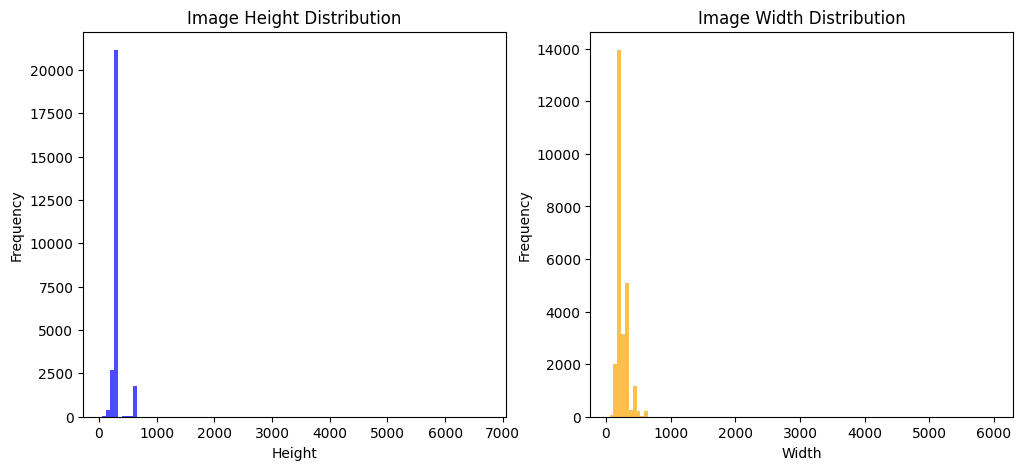

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df['Width'], bins=100, color='blue', alpha=0.7)
axes[0].set_title('Image Height Distribution')
axes[0].set_xlabel('Height')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Height'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('Image Width Distribution')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Frequency')

plt.show()

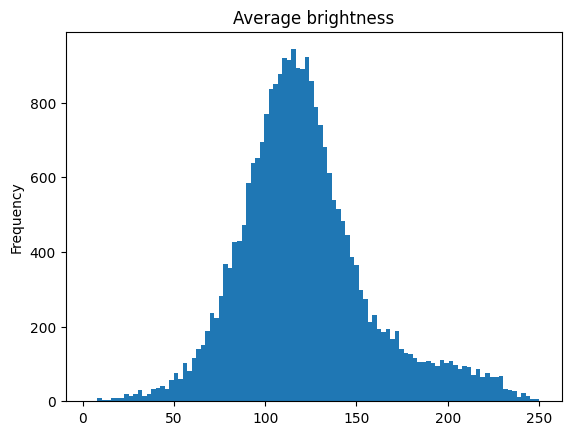

In [12]:
df['AverageBrightness'].plot(kind='hist', bins=100, title='Average brightness');

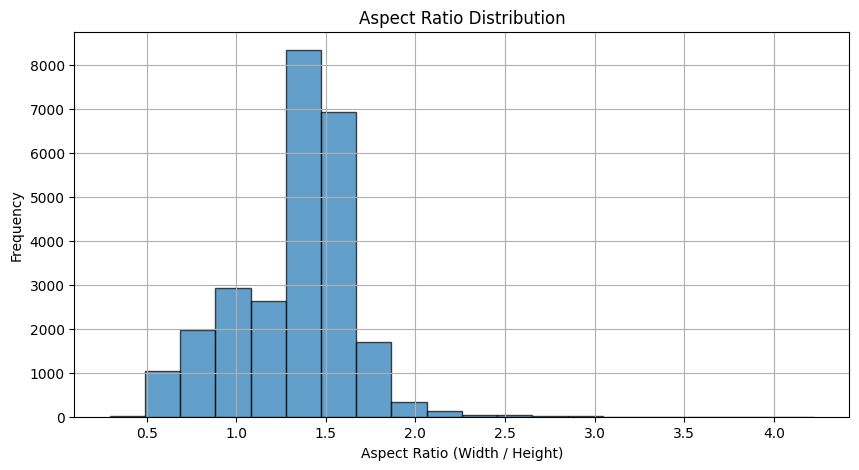

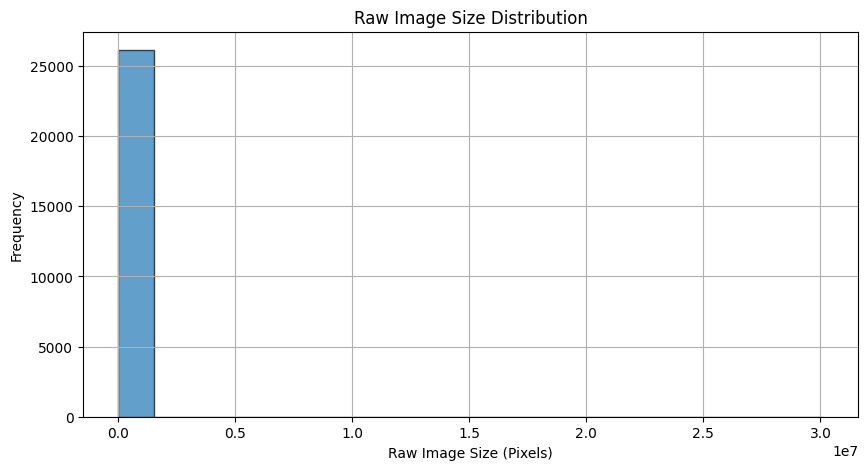

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['Aspect_Ratio'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.title('Aspect Ratio Distribution')
plt.grid(True)
plt.show()

# Plot Raw Size Distribution
plt.figure(figsize=(10, 5))
plt.hist(df['Raw_Size'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Raw Image Size (Pixels)')
plt.ylabel('Frequency')
plt.title('Raw Image Size Distribution')
plt.grid(True)
plt.show()

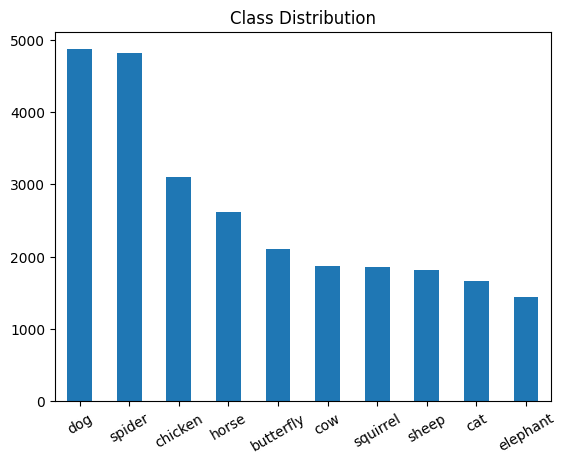

In [14]:
df['Label'].value_counts().plot(kind='bar', title='Class Distribution');
plt.xticks(rotation=30);

Dataset is not equally distributed by classes


two potential solutions:


- either reduce dog and spider classes images
- extend other classes that are < 2000 images

In [15]:
print("Amont of classes : ",len(df["Label"].unique()))

Amont of classes :  10


In [16]:
df['Label'].value_counts()

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: Label, dtype: int64

In [17]:
class AnimalDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
        
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir)) 
        self.images = []
        self.labels = []

        all_data = []  # Store all images before splitting

        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) 
                               if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_data.extend([(img, label_idx) for img in image_files])  

        random.shuffle(all_data)
        
        # Compute split indices
        total = len(all_data)
        train_end = int(total * train_ratio)
        valid_end = train_end + int(total * valid_ratio)

        # Split dataset
        if split == "train":
            data_subset = all_data[:train_end]
        elif split == "valid":
            data_subset = all_data[train_end:valid_end]
        elif split == "test":
            data_subset = all_data[valid_end:]
        else:
            raise ValueError("split must be 'train', 'valid', or 'test'")

        # Store images and labels
        self.images, self.labels = zip(*data_subset) if data_subset else ([], [])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(image_path).convert("RGB")  # Convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [18]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [19]:
train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

In [20]:
def draw_images(loader, limit=10):
    for (x_train, y_train) in loader:
        print('X_train:', x_train.size(), 'type:', x_train.type())
        print('y_train:', y_train.size(), 'type:', y_train.type())

        pltsize = 1
        plt.figure(figsize=(5 * pltsize, 2 * pltsize))

        for i in range(limit):
            plt.subplot(2, 5, i + 1)
            plt.axis('off')
            plt.imshow(x_train[i, 0, :, :].numpy(), cmap="gray_r")
            plt.title('Class: ' + str(y_train[i].item()))
        
        plt.show()

        break

In [21]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64, num_workers=2, pin_memory=True)

In [ ]:
draw_images(train_loader)

Планування на наступний етап:
- Визначте метрики, за якими будете оцінювати ефективність моделі;
- Заплануйте архітектуру нейронної мережі:
- Кількість згорткових шарів;
- Активації;
- Кількість повноз’язних шарів;
- Оптимізатор;
- Dropout.


### TBD